<center>
    <h1>Foundations of Large scale and distributed optimization <br> Image reconstruction in X-ray tomography </h1> <h2> 10 / 01 / 2024 </h2><br> <h2> Prof. Émilie Chouzenoux </h2> <br>
 <br>
</center>

Students : Valerio Guerini, Vincent Herfeld, Simon Queric


In [71]:
from scipy.io import loadmat
import scipy
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from time import time

## 1. X-ray tomography

In [2]:
G=loadmat('data/G.mat')['G']
H=loadmat('data/H.mat')['H']
true_x=loadmat('data/x.mat')['x']

In [3]:
sigma=1
M,N=H.shape
w=np.random.normal(loc=sigma,size=M)
y = H @ true_x + w.reshape(-1,1)
y = y.squeeze(1)
true_x = true_x.squeeze(1)

In [4]:
true_x.shape

(8100,)

In [5]:
np.linalg.norm(w)**2/2

16133.753895961574

In [6]:
y

array([1.68214438, 0.73395662, 0.10729061, ..., 0.23099985, 1.11606031,
       2.88796225])

In [7]:
np.linalg.norm(y - H@true_x)**2/2

16133.753895961574

In [8]:
two_dim_x=true_x.reshape((90,90),order='F')
two_dim_y=y.reshape((90,180),order='F')

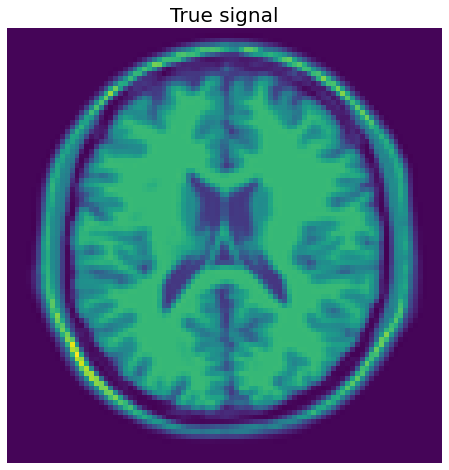

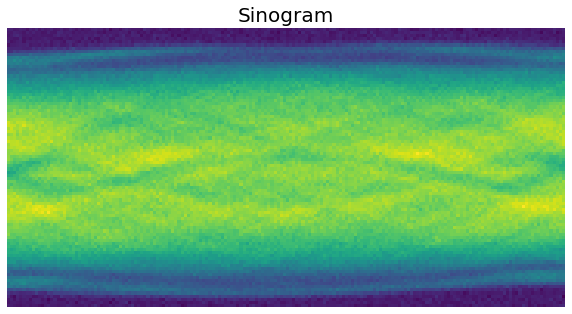

In [9]:
fig = plt.figure(figsize=(10, 8))
plt.title("True signal", fontsize=20)
plt.axis("off")
plt.imshow(two_dim_x)
fig = plt.figure(figsize=(10, 8))
plt.title("Sinogram", fontsize=20)
plt.axis("off")
plt.imshow(two_dim_y)
plt.show()

## 2. Optimization Problem 

### 2. 


Let's write $g_n$ the $n$-th rows of $G$.

We have that :

$$ \frac{\partial \psi}{\partial u} (u) = \frac{u}{\delta^2\sqrt{1+\frac{u^2}{\delta^2}}}$$

so

\begin{align*}
    \nabla r(x) & = \sum_{n=1}^{2N}\nabla \psi\circ [G \ \ \cdot \ \ ]^n(x)\\
    &= \sum_{n=1}^{2N}\nabla \psi\circ (g_n  \ \cdot \ )  (x) \\
    &=\sum_{n=1}^{2N}\frac{\partial \psi}{\partial u}(g_nx)g_n^T\\
    &= \sum_{n=1}^{2N}\left(\frac{1}{\delta^2\sqrt{1+\frac{(g_nx)^2}{\delta^2}}}g_n^Tg_n\right)x
\end{align*}

and finally: 

$$\boxed{\nabla f(x)= H^T(Hx-y)+ \lambda\sum_{n=1}^{2N}\left(\frac{g_n^Tg_n}{\delta^2\sqrt{1+\frac{([Gx]^n)^2}{\delta^2}}}\right)x}$$

### 3. 

\begin{align*}
    \lVert \nabla f(x)- \nabla f(z) \rVert &= \lVert H^TH(x-z) + \lambda\sum_{n=1}^{2N}\left(\frac{g_n^Tg_n}{\delta^2\sqrt{1+\frac{(g_nx)^2}{\delta^2}}}\right)(x-z) \rVert \\
    & \leq \lVert H^TH(x-z) \rVert + \lambda \left\lVert \sum_{n=1}^{2N}\left(\frac{g_n^Tg_n}{\delta^2\sqrt{1+\frac{(g_nx)^2}{\delta^2}}}\right)(x-z) \right\rVert
\end{align*}

Moreover, $\frac{1}{\sqrt{1+(L_n(G)x)^2}} \leq 1$, so :

\begin{align*}
\lVert \nabla f(x)- \nabla f(z) \rVert &\leq \lVert H^TH(x-z) \rVert + \frac{\lambda}{\delta^2} \left\lVert \underbrace{\sum_{n=1}^{2N}g_n^Tg_n}_{G^TG}(x-z) \right\rVert \\
&\leq \lVert H^TH(x-z) \rVert + \frac{\lambda}{\delta^2} \lVert G^TG(x-z) \rVert 
\end{align*}

By definition of the operator norm : $\lVert M(x-z) \rVert \leq \lVert M \rVert \lVert (x-z) \rVert$ and since the operator norm is sub-multiplicative and $\lVert M \rVert= \lVert M^T \rVert$ , we finally have:

\begin{align*}
\lVert \nabla f(x)- \nabla f(z) \rVert &\leq \lVert H^TH\rVert \lVert(x-z) \rVert + \frac{\lambda}{\delta^2} \lVert G^TG\rVert \lVert(x-z) \rVert \\
& \leq \left(\lVert H \rVert^2 +\frac{\lambda}{\delta^2} \lVert G \rVert^2\right)\lVert(x-z) \rVert 
\end{align*}

So $L=\left(\lVert H \rVert^2 +\frac{\lambda}{\delta^2} \lVert G \rVert^2\right)$ is indeed a Lipschitz constant of $\nabla f$.

## 3. Optimization algorithms
### 3.1 Gradient descent algorithm

In [10]:
lam,delta=0.13,0.02
norm_H=scipy.sparse.linalg.svds(H,k=1,which='LM')[1][0]
norm_G=scipy.sparse.linalg.svds(G,k=1,which='LM')[1][0]

L=norm_H**2+(lam/delta**2)*norm_G**2
print(L)
x0 = np.zeros(8100)
n_iter = 10

18092.773276864802


In [11]:
def psi(u, delta):
    return np.sqrt(1+u**2/delta**2)
def f(x, H, G, y, delta):
    return np.linalg.norm(H@x-y)**2/2 + lam*np.sum(psi(G@x, delta))

In [12]:
np.linalg.norm(H@true_x-y)**2/2

16133.753895961574

In [13]:
np.linalg.norm(w)**2/2

16133.753895961574

In [14]:
f(true_x, H, G, y, delta) 

22676.831914456856

In [15]:
f(np.zeros(N), H, G, y, delta) 

7267785.492880943

In [66]:
x0=np.zeros(N)

def grad_f(x,y=y,H=H,G=G,lam=lam,delta=delta):
    
    left_term = H.T@(H@x-y)    
    Gx = G@x
    right_term = lam/delta**2 * G.T.dot(Gx/np.sqrt(1+np.square(Gx/delta)))
    return (left_term + right_term)

def grad_descent(x0,L, eps, n_steps, lam=lam, delta=delta): 
    x=np.copy(x0)
    evolution = [f(x, H, G, y, delta=delta)]
    norms = []
    
    for n in range(n_steps):
        g = grad_f(x, lam=lam, delta=delta)
        x-= 2/L*g
        evolution.append(f(x, H, G, y, delta=delta))
        norms.append(np.linalg.norm(g))
        if norms[-1]<=eps : 
            break
    return x, evolution, norms

In [68]:
grad_f(x=true_x,y=y,H=H,G=G,lam=lam,delta=delta)

array([ -94.57559271, -100.84160419,  -98.56289099, ..., -101.74171102,
        -94.81902457,  -93.20862443])

In [69]:
np.sqrt(N)

90.0

In [72]:
start = time()
x, evol_gradmethod, norms_gradmethod = grad_descent(x0, L, eps=np.sqrt(N)*10**-4, n_steps=3000)
end = time()

In [73]:
print("Number of iterations :", len(norms_gradmethod))

Number of iterations : 2482


In [74]:
print("Running time : {:.1f} s".format(end-start))

Running time : 85.8 s


In [75]:
f(x, H, G, y, delta) 

12869.765426286333

In [76]:
np.linalg.norm(grad_f(x))

0.008953750974295682

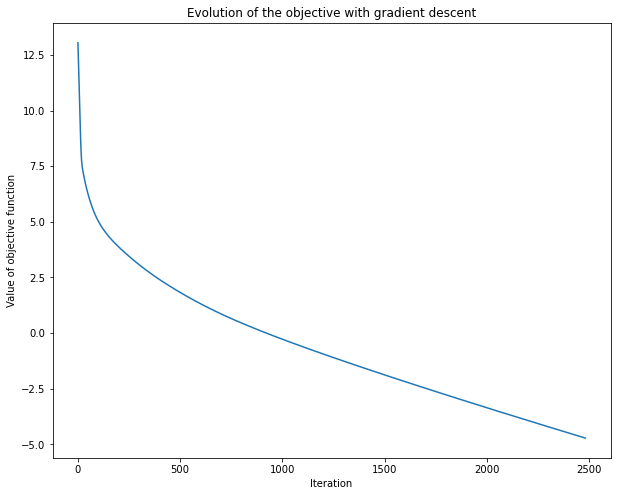

In [77]:
fig = plt.figure(figsize=(10, 8))
plt.title("Evolution of the objective with gradient descent")
plt.xlabel("Iteration")
plt.ylabel("Value of objective function")
plt.plot(np.log(norms_gradmethod))
plt.show()

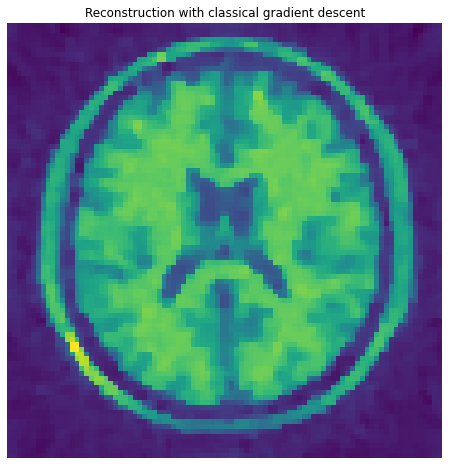

In [78]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(x.reshape((90,90),order='F'))
plt.title("Reconstruction with classical gradient descent")
plt.axis("off")
plt.show()

### 3.2 MM quadratic algorithm

We want to find a quadratic majorant of $f$ at $x$. 

Let $u, v \in \mathbb{R}^N$.

We have for $n \in [1, 2N]$ : 

$$ \psi(g_n v) \leqslant \psi(g_n u) + \psi'(g_n u)g_n(v -u) + \frac{1}{2}\omega(|g_nu|)(g_n(v-u))^2$$

We sum this inequality which gives us : 

$$ r(v) \leqslant r(u) + \nabla r(u)^T(v-u) + \frac{1}{2}\|G(v - u)\|^2_{\Omega(u)}$$

where $\omega(x) = (1/\delta^2)(1+x^2/\delta^2)^{-1/2} ,\Omega(u) = \text{diag}(\omega(g_1u), \cdots, \omega(g_nu))$

Then, for $z, x \in \mathbb{R}^n$ : 

\begin{align*}
 f(z) &=  \frac{1}{2}\| Hz - y\|^2 + \lambda r(z) \\
      &\leqslant f(x) + \nabla f(x)^T(z-x) + \frac{1}{2}\left(\lambda\|G(z - x)\|^2_{\Omega(x)} + \|H(z -x)\|^2_2\right)
\end{align*}

We can take $A(x) = \sqrt{\lambda}G^T\Omega(x)G + H^TH$

Then, the MM algorithm writes 

$$ x_{n+1} = x_n − \theta_nA(x_n)^{-1}\nabla f(x_n), \theta_n \in (0, 2)$$

In [22]:
HTH = H.T@H

In [26]:
def MM_algorithm(x0, y, H, G, eps, theta, delta, n_iter) :
    x = np.copy(x0)
    evolution = [f(x, H, G, y, delta)]
    norms = []
    for _ in range(n_iter):
        grad = grad_f(x)
        Ax = A(x, G, delta)
        b = theta*grad 
        x -= scipy.sparse.linalg.bicg(Ax, b, maxiter=100)[0]
        evolution.append(f(x, H, G, y, delta))
        norms.append(np.linalg.norm(grad))
        if norms[-1]<=eps : 
            break
    return x, evolution, norms

In [27]:
theta = 1.

In [29]:
start = time()
x, evol_MM, norms_MM = MM_algorithm(x0, y, H, G, eps=np.sqrt(N)**10**-4, theta=1, delta=delta, n_iter=210)
end = time()

In [106]:
print("Norm of the gradient : {:.4f}".format(np.linalg.norm(grad_f(x))))

Norm of the gradient : 0.9653


In [107]:
print("Running time : {:.1f} s".format(end-start))

Running time : 243.9 s


In [108]:
print("Value of the objective : {:.2f}".format(f(x, H, G, y, delta)))

Value of the objective : 13025.55


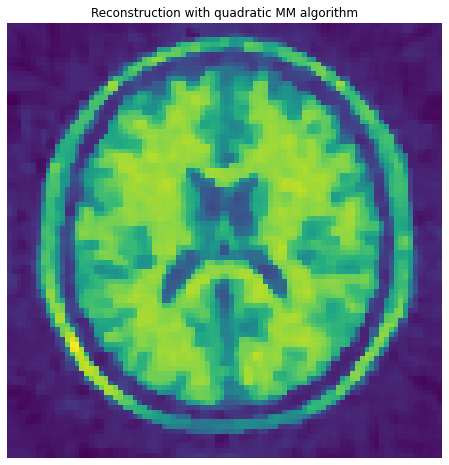

In [109]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(x.reshape((90,90),order='F'))
plt.title("Reconstruction with quadratic MM algorithm")
plt.axis("off")
plt.show()

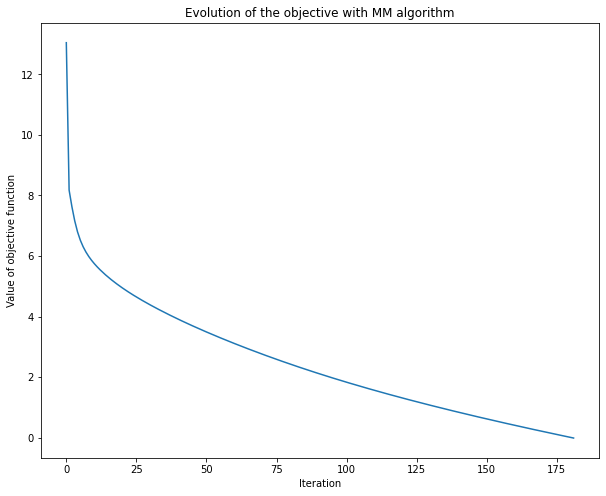

In [110]:
fig = plt.figure(figsize=(10, 8))
plt.title("Evolution of the objective with MM algorithm")
plt.xlabel("Iteration")
plt.ylabel("Value of objective function")
plt.plot(np.log(norms_MM))
plt.show()

In [166]:
f(x, H, G, y, delta)

12775.863556364566

### 3.3 3MG algorithm

In [169]:
def A(x, G, delta, D_k, HTH) : 
    N = x.shape[0]
    Gx = (G@x).reshape(-1, 1) 
    d = omega(Gx, delta)
    Omega_x = scipy.sparse.diags(d[:,0]).tocsc()
    GD_k = G@D_k
    return GD_k.T@Omega_x@GD_k + D_k.T@HTH@D_k 

In [172]:
def MMMG_algorithm(x0, y, H, G, delta, lam, n_iter) :
    x = np.copy(x0)
    evolution = [f(x, H, G, y, delta)]
    #the first step is particular because Dk is of dimension 1
    grad=grad_f(x0)
    Dk=-grad
    #with argument DK given, A compute directly the matrix product Dk^TA(xk)Dk
    Ax = A(x, G, delta, Dk, HTH)
    uk = 1/Ax * (Dk.T @ grad)
    previous=np.copy(x)
    x += Dk * uk
    evolution.append(f(x, H, G, y, delta))
    norms = []
    #end of the first step, now the general step:
    for _ in range(n_iter-1):
        grad = grad_f(x)
        Dk=np.vstack((grad,x-previous)).T
        Ax = A(x, G, delta, Dk, HTH)
        uk=-scipy.linalg.pinv(Ax) @ (Dk.T @ grad)
        previous=np.copy(x)
        x += Dk @ uk
        evolution.append(f(x, H, G, y, delta))
        norms.append(np.linalg.norm(grad))
        if norms[-1]<=np.sqrt(N)*10**-4 : 
            break
    return x, evolution, norms

In [173]:
grad=grad_f(x0)
Dk=-grad
#with argument DK given, A compute directly the matrix product Dk^TA(xk)Dk
Ax = A(x, G, delta, Dk, HTH)

In [174]:
Ax

3317200261047277.0

In [176]:
start = time()
x, evol_3MG, norms_3MG = MMMG_algorithm(x0, y, H, G, delta, lam, n_iter=200)
end = time()

In [177]:
print("Norm of the gradient : {:.4f}".format(np.linalg.norm(grad_f(x))))
print("Running time : {:.1f} s".format(end-start))
print("Value of the objective : {:.2f}".format(f(x, H, G, y, delta)))

Norm of the gradient : 0.6762
Running time : 83.8 s
Value of the objective : 13025.55


In [178]:
len(evol_3MG)

201

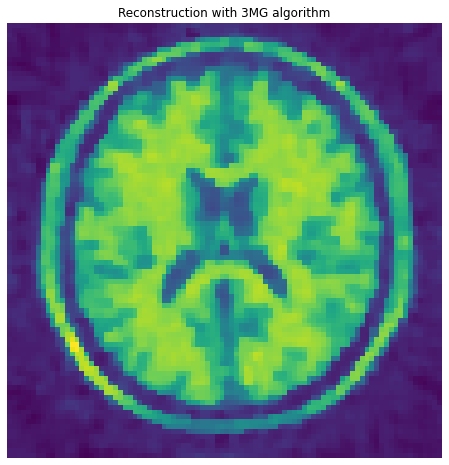

In [179]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(x.reshape((90,90),order='F'))
plt.title("Reconstruction with 3MG algorithm")
plt.axis("off")
plt.show()

In [195]:
np.linalg.norm(grad_f(x))

11126.977315197259

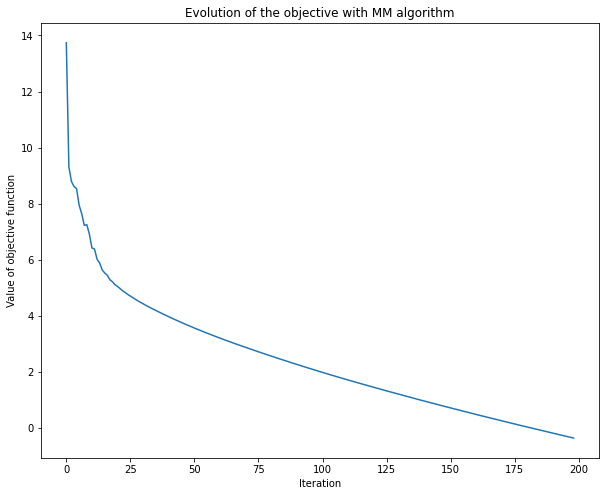

In [180]:
fig = plt.figure(figsize=(10, 8))
plt.title("Evolution of the objective with MM algorithm")
plt.xlabel("Iteration")
plt.ylabel("Value of objective function")
plt.plot(np.log(norms_3MG))
plt.show()

### 3.4 Block-coordinate MM quadratic algorithm

In [122]:
Ks = [1, 2, 3, 5, 6, 9]

def Aj_x(Ax,j,Nj):
    return Ax[(j-1)*Nj:j*Nj,(j-1)*Nj:j*Nj]

In [123]:
def MM_algorithm(x0, y, H, G, theta, delta, lam, n_iter) :
    x = np.copy(x0)
    evolution = []
    for _ in range(n_iter):
        grad = grad_f(x)
        Ax = A(x, G, HTH, delta, lam)
        b = theta*grad 
        x -= scipy.sparse.linalg.bicg(Ax, b)[0]
        evolution.append(f(x, H, G, y, delta))
    return x, evolution

In [124]:
def BCMM_algorithm(x0,y,H,G,theta,delta,lam,n_iter,K):
    x = np.copy(x0)
    evolution = []
    N=x0.shape[0]
    Nj=N//K
    for n in range(1,n_iter+1):
        j=(n-1)%K+1
        grad = grad_f(x)[(j-1)*Nj:j*Nj]
        Ajx=Aj_x(A(x, G, HTH, delta, lam),j,Nj)
        b=theta*grad
        x[(j-1)*Nj:j*Nj]-=scipy.sparse.linalg.bicg(Ajx, b)[0]
        evolution.append(f(x, H, G, y, delta))
    return x,evolution

In [125]:
theta = 1.

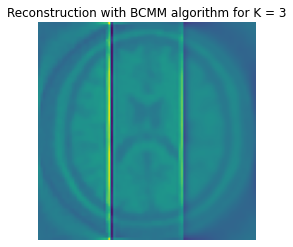

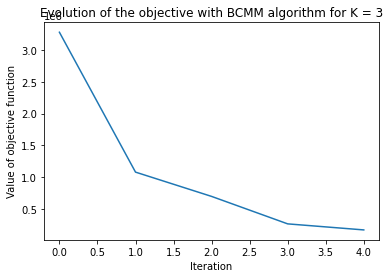

In [126]:
BCMM_xs,BCMM_evolutions=[],[]
for K in [Ks[2]]:
    BCMM_x,BCMM_evolution = BCMM_algorithm(x0,y,H,G,theta,delta,lam,5,K)
    BCMM_xs.append(BCMM_x)
    BCMM_evolutions.append(BCMM_evolution)
    plt.imshow(BCMM_x.reshape((90,90),order='F'))
    plt.title("Reconstruction with BCMM algorithm for K = " + str(K))
    plt.axis("off")
    plt.show()

    plt.title("Evolution of the objective with BCMM algorithm for K = " + str(K))
    plt.xlabel("Iteration")
    plt.ylabel("Value of objective function")
    plt.plot(BCMM_evolution)
    plt.show()


Our implementation of block coordinate descent is not conclusive. We didn't have time to investigate what was wrong with it.

### 3.5 Parallel MM quadratic algorithm


#### Question 1

Let's show that $A(x) \preccurlyeq B(x)$.

Let $u \in \mathbb{R}^N$.

We'll show that $H^TH \preccurlyeq \text{diag}(\mathcal{H}_i^T1)$ and that $G^T\Omega(x)G \preccurlyeq \text{diag}(\mathcal{G}_i^T\omega(Gx))$. 

Let's show the first inequality :  

\begin{align*}
u^TH^THu &= \|Hu\|^2_2 \\
         &= \sum_{m=1}^M{(Hu)_m^2} \\
         &= \sum_{m=1}^M{\left(\sum_{i=1}^N{H^{(m, i)}u_i}\right)^2} \\
         &\leqslant \sum_{m=1}^M{\left(\sum_{i=1}^N{|H^{(m, i)}u_i}|\right)^2} \text{ by triangle inequality and by the fact that } x \mapsto x^2 \text{ is non-decreasing}.\\
         &\leqslant \sum_{m=1}^M{\sum_{i=1}^N{u_i^2 |H^{(m, i)}|\sum_{p=1}^N{|H^{(m, p)}|}}} \text{ thanks to Jensen's inequality, since } x \mapsto x^2 \text{ is convex. We use the weigths } |H^{(m, i)}|/\sum_{p=1}^N{|H^{(m, p)}|} \\
         &= u^T\text{diag}(\mathcal{H}_i^T1)u
\end{align*}

Let's show the second inequality :  

\begin{align*}
u^TG^T \Omega(x) Gu &= \sum_{n=1}^{2N}{(Gu)_n^2\omega(g_nx)} \\
                    &= \sum_{n=1}^{2N}{\omega(g_nx)\left(\sum_{i=1}^N{G^{(n, i)}u_i} \right)^2} \\
                    & \leqslant \sum_{n=1}^{2N}{\omega(g_nx)\left(\sum_{i=1}^N{|G^{(n, i)}u_i|} \right)^2} \text{ by triangle inequality and by the fact that } x \mapsto x^2 \text{ is non-decreasing}.\\
                    &\leqslant \sum_{n=1}^{2N}{\omega(g_nx)\sum_{i=1}^N{u_i^2 |G^{(n, i)}|\sum_{p=1}^N{|G^{(n, p)}|}}} \text{ by Jensen's inequality once again}\\
                    &= u^T \text{diag}(\mathcal{G}_i^T\omega(Gx))u
\end{align*}

We conclude that $A(x) \preccurlyeq B(x)$ so that we can apply the MM algorithm with the curvature $B(x)$.

#### Question 2

In order to implement the MM algorithm, we should update each coordinate of $x_k$ since $B(x)$ is diagonal.


### 3.6 Comparison of the methods

### Question 2


| Method | Number of iterations | Running time | Value of the objective|
|:------:|:-------:|:-------:|:-------:|
|Gradient descent| 2266 |  67.2 s | 13025.55 |
|Quadratic MM algorithm| 202| 3 min | 13025.55 |
|3MG algorithm| 200 |  82.7 s| 13025.55 |
|Block-coordinate MM | NA | NA | NA |

In [163]:
t = np.log(np.arange(1, len(norms_gradmethod[:201]))+1)

len(t)

200

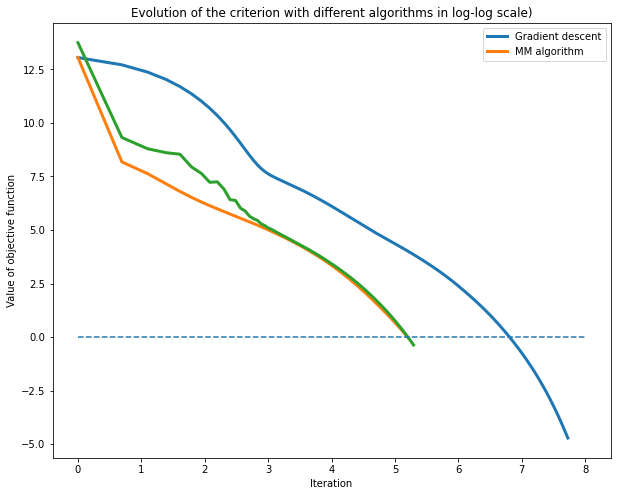

In [184]:
fig = plt.figure(figsize=(10, 8))
plt.title("Evolution of the criterion with different algorithms in log-log scale")
plt.xlabel("Iteration")
plt.ylabel("Value of objective function")
t = np.log(np.arange(len(norms_gradmethod))+1)
plt.plot(t, np.log(norms_gradmethod[:]), lw=3)
t = np.log(np.arange(1, len(norms_MM)+1))
plt.plot(t, np.log(norms_MM), lw=3)
t = np.log(np.arange(1, len(norms_3MG)+1))
plt.plot(t, np.log(norms_3MG), lw=3)
plt.hlines(np.sqrt(N)*10**-4, xmin=0, xmax=8, ls="--")
plt.legend(["Gradient descent", "MM algorithm"])
plt.show()

### Question 3

In [19]:
def SNR(x, xtrue):
    return 20*np.log(np.linalg.norm(xtrue)/np.linalg.norm(xtrue - x))

In [20]:
lambdas = [0.05, 0.1, 0.5, 1, 10]
deltas = [0.02, 0.1, 0.5, 1]

In [21]:
snr_min = np.inf
SNRS = []
for l in lambdas : 
    for d in deltas :
        x, _, _ = grad_descent(x0, L, eps=np.sqrt(N)*10**-4, n_steps=100, lam=l, delta=d)
        snr = SNR(x, true_x)
        SNRS.append(snr)
        if snr < snr_min :
            lstar = l
            dstar = d 
            snr_min = snr

In [63]:
print("Best hyperparameters : lambda an delta :", lstar, dstar)

Best hyperparameters : lambda an delta : 10 0.02


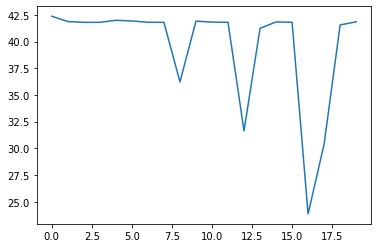

In [64]:
plt.plot(SNRS)
plt.show()

With gradient descent, we find hyperparameters that minimize the SNR : $\lambda = 10$ and $\delta = 0.02$